In [ ]:
!pip install tensorflow opencv-python labelme albumentations

To test this model on live video, run the following blocks:<br>
1) Necessary imports
2) Necessary functions
3) Augmenting our raw data: Loading up augmented data into our program
4) Saving our model and then loading it back again: Reloading model
5) Saving our model and then loading it back again: Analyzing the model's performance on live video

# Necessary imports

In [1]:
import os
import time
import uuid
import cv2

import tensorflow as tf
import json
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import load_model

# Necessary functions

In [2]:
def load_image(x):
    byte_image = tf.io.read_file(x)
    image = tf.io.decode_jpeg(byte_image)
    return image

In [3]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = 'utf-8') as f:
        label = json.load(f)
    return [label['class']], label['bboxes']

# Getting our data

In [ ]:
images = 30

for folder in ['train', 'test', 'val']:
    cap = cv2.VideoCapture(0)
    for num in range(images):
        ret, frame = cap.read()
        print('Capturing image', num, ':',ret)
        imagename = os.path.join('data', folder, 'images', f'{str(uuid.uuid1())}.jpg')
        cv2.imwrite(imagename, frame)
        cv2.imshow('frame',frame)
        time.sleep(0.5)

        if cv2.waitKey(1) & 0xFF == ord('q'): break

    cap.release()
    cv2.destroyAllWindows()

In [ ]:
!labelme

# Review dataset and building a image loading function

### Setting up memory usage limit

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

### Splitting up files (Do this if already not separated)

In [456]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data',folder,'images')):
        filename = file.split('.')[0] + '.json'
        current_path = os.path.join('data','labels',filename)
        if os.path.exists(current_path):
            new_path = os.path.join('data',folder,'labels',filename)
            os.replace(current_path, new_path)

### Viewing our dataset

In [7]:
images = tf.data.Dataset.list_files('data\\train\\images\\*.jpg', shuffle=True)
images.as_numpy_iterator().next()

b'data\\train\\images\\38bb6053-69f2-11ef-a3e1-98e74370d1d3.jpg'

In [9]:
images = images.map(load_image)

In [6]:
image_generator = images.batch(4).as_numpy_iterator()

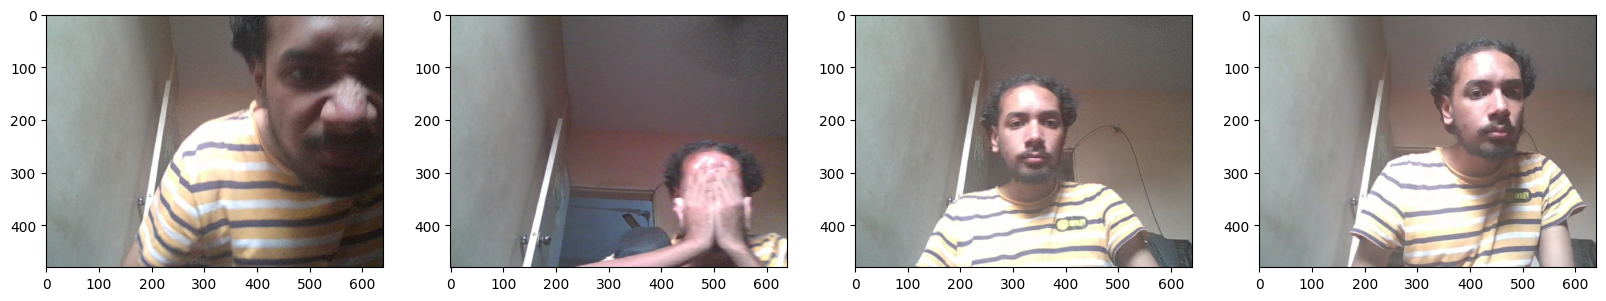

In [7]:
plot_images = image_generator.next()
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()

# Augmenting our raw data

### Random image augmentation

In [8]:
import albumentations as alb

d:\Python\Python312\Lib\site-packages\albumentations\check_version.py:49: UserWarning: Error fetching version info <urlopen error [Errno 11001] getaddrinfo failed>
  data = fetch_version_info()


In [9]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450),
                         alb.HorizontalFlip(p = 0.5),
                         alb.RandomBrightnessContrast(p = 0.2),
                         alb.RandomGamma(p = 0.2),
                         alb.RGBShift(p = 0.2),
                         alb.VerticalFlip(p = 0.5)],
                        bbox_params=alb.BboxParams(format='albumentations', label_fields=['class_labels']))

In [10]:
random_image = cv2.cvtColor(cv2.imread(os.path.join('data','train','images','362a2f00-69f2-11ef-b233-98e74370d1d3.jpg')), cv2.COLOR_RGB2BGR)

In [11]:
with open(os.path.join('data','train','labels','362a2f00-69f2-11ef-b233-98e74370d1d3.json'), 'r') as f:
    random_label = json.load(f)

In [12]:
random_label['shapes'][0]['points']

[[298.6111111111111, 104.44444444444444],
 [475.27777777777777, 316.11111111111114]]

In [13]:
formatted_label = np.array(random_label['shapes'][0]['points']).reshape(4)/[640, 480, 640, 480]

In [14]:
augmented = augmentor(image=random_image, bboxes=[formatted_label], class_labels=['face'])
augmented.keys()

dict_keys(['image', 'bboxes', 'class_labels'])

In [15]:
augmented['image']

array([[[210, 201, 204],
        [205, 201, 198],
        [206, 207, 201],
        ...,
        [143, 149, 147],
        [144, 150, 148],
        [148, 154, 152]],

       [[203, 188, 183],
        [199, 189, 177],
        [202, 195, 179],
        ...,
        [135, 140, 136],
        [134, 139, 135],
        [141, 147, 145]],

       [[206, 186, 175],
        [210, 193, 175],
        [210, 195, 174],
        ...,
        [139, 145, 141],
        [136, 142, 138],
        [138, 144, 142]],

       ...,

       [[ 97,  96,  94],
        [ 92,  88,  87],
        [ 94,  90,  89],
        ...,
        [161, 167, 163],
        [161, 167, 163],
        [161, 167, 163]],

       [[108, 107, 105],
        [106, 102, 101],
        [103,  99,  98],
        ...,
        [162, 168, 164],
        [162, 168, 164],
        [162, 168, 164]],

       [[ 94,  93,  91],
        [ 98,  94,  93],
        [101,  97,  96],
        ...,
        [161, 167, 163],
        [163, 169, 165],
        [163, 170, 163]]

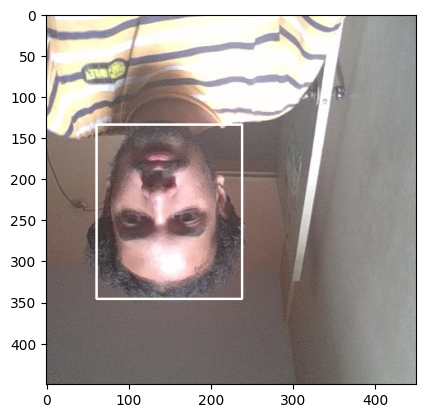

In [16]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450, 450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450, 450]).astype(int)),
              (255, 255, 255), 2)
plt.imshow(augmented['image'])

### Build and run complete image augmentation pipeline

In [473]:
for folder in ['train','test','val']:
    for image_name in os.listdir(os.path.join('data',folder,'images')):
        image_path = os.path.join('data',folder,'images',image_name)
        img = cv2.imread(image_path)
        label_path = os.path.join('data',folder,'labels',f'{image_name.split('.')[0]}.json')

        if os.path.exists(label_path):
            with open(label_path, 'r') as f: label = json.load(f)
        
            formatted_label = np.array(label['shapes'][0]['points']).reshape(4)/[640, 480, 640, 480]

        try:
            for iteration in range(40):
                augmented = augmentor(image = img, bboxes = [formatted_label], class_labels = ['face'])
                augmented_image_path = os.path.join('aug_data',folder,'images',f'{image_name.split('.')[0]}.{iteration}.jpg')
                augmented_label_path = os.path.join('aug_data',folder,'labels',f'{image_name.split('.')[0]}.{iteration}.json')
                cv2.imwrite(augmented_image_path, augmented['image'])

                annotation = {}
                annotation['image'] = image_path

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0:
                        annotation['bboxes'] = [0,0,0,0]
                        annotation['class'] = 0
                    else:
                        annotation['bboxes'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else:
                    annotation['bboxes'] = [0,0,0,0]
                    annotation['class'] = 0

                with open(augmented_label_path, 'w') as f: json.dump(annotation, f)

        except Exception as e:
            print(e)

### Loading up augmented data into our program

In [4]:
train_aug_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_aug_images = train_aug_images.map(load_image)
train_aug_images = train_aug_images.map(lambda x: tf.image.resize(x, (120, 120)))
train_aug_images = train_aug_images.map(lambda x: x/255)

test_aug_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_aug_images = test_aug_images.map(load_image)
test_aug_images = test_aug_images.map(lambda x: tf.image.resize(x, (120, 120)))
test_aug_images = test_aug_images.map(lambda x: x/255)

val_aug_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_aug_images = val_aug_images.map(load_image)
val_aug_images = val_aug_images.map(lambda x: tf.image.resize(x, (120, 120)))
val_aug_images = val_aug_images.map(lambda x: x/255)

In [5]:
train_aug_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_aug_labels = train_aug_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

test_aug_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle = False)
test_aug_labels = test_aug_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

val_aug_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle = False)
val_aug_labels = val_aug_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [6]:
train = tf.data.Dataset.zip((train_aug_images, train_aug_labels))
train = train.shuffle(2500)
train = train.batch(8)
train = train.prefetch(4)

test = tf.data.Dataset.zip((test_aug_images, test_aug_labels))
test = test.shuffle(700)
test = test.batch(8)
test = test.prefetch(4)

val = tf.data.Dataset.zip((val_aug_images, val_aug_labels))
val = val.shuffle(700)
val = val.batch(8)
val = val.prefetch(4)

### Viewing random batches of augmented data

In [7]:
random_sample = train.as_numpy_iterator()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


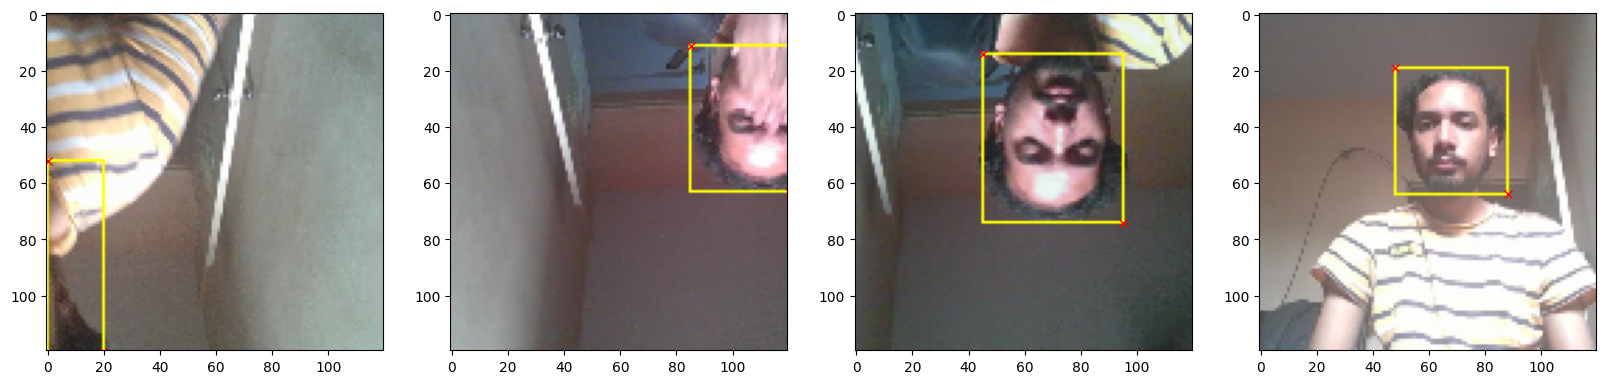

In [8]:
batch = random_sample.next()

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample_image = batch[0][idx]
    sample_label = batch[1][1][idx]
    
    sample_image = np.array(sample_image)
    ax[idx].plot(np.multiply(sample_label[[0,2]],[120,120]).astype(int), np.multiply(sample_label[[1,3]],[120,120]).astype(int), 'rx')
    cv2.rectangle(sample_image,
                  tuple(np.multiply(sample_label[:2], [120, 120]).astype(int)),
                  tuple(np.multiply(sample_label[2:], [120, 120]).astype(int)), (255,255,0), 1)
    ax[idx].imshow(sample_image)
    

# Building Deeplearning model using Functional API

In [31]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [32]:
vgg16 = VGG16(include_top=False)
vgg16.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
def build_model():
    input_layer = tf.keras.layers.Input(shape=(120,120,3))

    vgg16 = VGG16(include_top=False)(input_layer)

    #Classification model
    f1 = tf.keras.layers.GlobalMaxPooling2D()(vgg16)
    class1 = tf.keras.layers.Dense(2048, activation='relu')(f1)
    class2 = tf.keras.layers.Dense(1, activation='sigmoid')(class1)

    #Regression model
    f2 = tf.keras.layers.GlobalMaxPooling2D()(vgg16)
    reg1 = tf.keras.layers.Dense(2048, activation='relu')(f2)
    reg2 = tf.keras.layers.Dense(4, activation='sigmoid')(reg1)

    facetracker = tf.keras.Model(inputs = input_layer, outputs = [class2, reg2])

    return facetracker

In [34]:
facetracker = build_model()
facetracker.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 120, 120,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 3, 3, 512) │ 14,714,688 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 2048)      │  1,050,624 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2048)      │  1,050,624 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │      2,049 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 4)         │      8,196 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 16,826,181 (64.19 MB)

 Trainable params: 16,826,181 (64.19 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
X, y = train.as_numpy_iterator().next()
classes, coords = facetracker.predict(X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


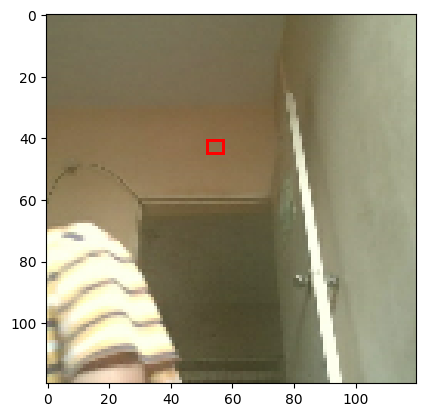

In [36]:
num = 0
image = np.copy(X[num])
cv2.rectangle(image,
              tuple(np.multiply(coords[num][:2],[120, 120]).astype(int)),
              tuple(np.multiply(coords[num][2:],[120, 120]).astype(int)),
              (255,0,0),1
              )
plt.imshow(image)

In [50]:
batches_per_epoch = len(train)
lr_decay = ((1/0.75) - 1)/ batches_per_epoch
lr_decay

0.001111111111111111

In [51]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay = lr_decay)

d:\Python\Python312\Lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [52]:
def localization_loss(y_true, y_pred):
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - y_pred[:,:2]) + tf.square(y_true[:,2:] - y_pred[:,2:]))

    h_true = y_true[:,3] - y_true[:,1]
    w_true = y_true[:,2] - y_true[:,0]

    h_pred = y_pred[:,3] - y_pred[:,1]
    w_pred = y_pred[:,2] - y_pred[:,0]

    delta_size = tf.reduce_sum(tf.square(h_true - h_pred) + tf.square(w_true - w_pred))
    
    return delta_coord + delta_size

In [53]:
classloss = tf.keras.losses.BinaryCrossentropy()
regloss = localization_loss

In [54]:
print(f'Classification loss: {classloss(y[0], classes).numpy()}')
print(f'Regression loss: {regloss(y[1], coords).numpy()}')

Classification loss: 0.621222734451294
Regression loss: 3.8477272987365723


# Train a Neural network

In [55]:
class FaceTracker(Model):
    def __init__(self, facetracker, **kwargs):
        super().__init__(**kwargs)
        self.model = facetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt

    def train_step(self, batch, **kwargs):
        X, y = batch
        
        with tf.GradientTape() as tape:
            classes, coords = self.model(X, training=True)
            
            y[0].set_shape([None,1])
            batch_closs = self.closs(y[0], classes)
            batch_lloss = self.lloss(tf.cast(y[1], tf.float32), coords)

            total_loss = batch_lloss + 0.5*batch_closs

            grad = tape.gradient(total_loss, self.model.trainable_variables)

        opt.apply_gradients(zip(grad, self.model.trainable_variables))

        return {'total_loss': total_loss, 'class_loss': batch_closs, ' localization_loss': batch_lloss}
    
    def test_step(self, batch, **kwargs):
        X, y = batch

        classes, coords = self.model(X, training = False)

        y[0].set_shape([None,1])
        batch_closs = self.closs(y[0], classes)
        batch_lloss = self.lloss(tf.cast(y[1],tf.float32), coords)

        total_loss = batch_lloss+ 0.5*batch_closs

        return {'total_loss': total_loss, 'class_loss': batch_closs, 'localization_loss': batch_lloss}
    
    def call(self, X, **kwargs):
        return self.model(X, **kwargs)


In [56]:
model = FaceTracker(facetracker=facetracker)
model.compile(opt=opt, classloss= classloss, localizationloss=regloss)

logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

hist = model.fit(train, epochs=30, validation_data = val, callbacks = [tensorboard_callback])

Epoch 1/30


300/300 ━━━━━━━━━━━━━━━━━━━━ 918s 3s/step -  localization_loss: 1.0106 - class_loss: 0.1500 - total_loss: 1.0856 - val_class_loss: 0.0016 - val_localization_loss: 0.0872 - val_total_loss: 0.0880
Epoch 2/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 930s 3s/step -  localization_loss: 0.2598 - class_loss: 0.0529 - total_loss: 0.2863 - val_class_loss: 0.0051 - val_localization_loss: 0.1031 - val_total_loss: 0.1057
Epoch 3/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 1112s 4s/step -  localization_loss: 0.2870 - class_loss: 0.0581 - total_loss: 0.3160 - val_class_loss: 8.0064e-05 - val_localization_loss: 0.0640 - val_total_loss: 0.0640
Epoch 4/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 942s 3s/step -  localization_loss: 0.1559 - class_loss: 0.0358 - total_loss: 0.1738 - val_class_loss: 7.0843e-04 - val_localization_loss: 0.0498 - val_total_loss: 0.0502
Epoch 5/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 929s 3s/step -  localization_loss: 0.1126 - class_loss: 0.0283 - total_loss: 0.1268 - val_class_loss: 8.0560e-04 - val_localization_loss: 

### Plotting the losses for the train and validation data

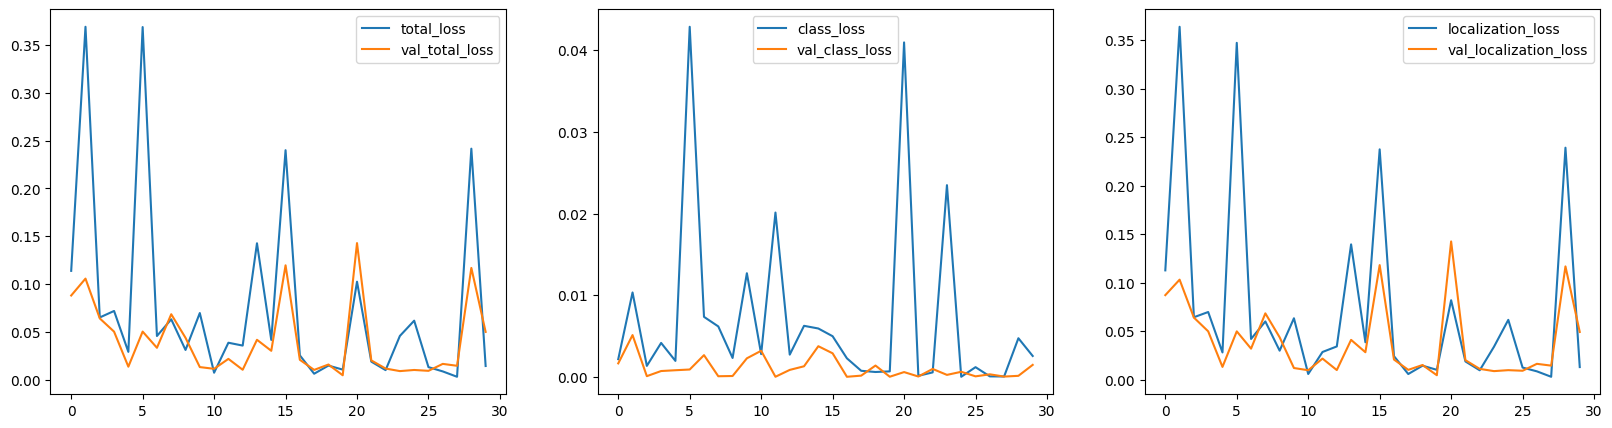

In [71]:
fig, ax = plt.subplots(ncols = 3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], label = 'total_loss')
ax[0].plot(hist.history['val_total_loss'], label = 'val_total_loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], label = 'class_loss')
ax[1].plot(hist.history['val_class_loss'], label = 'val_class_loss')
ax[1].legend()

ax[2].plot(hist.history[' localization_loss'], label = 'localization_loss')
ax[2].plot(hist.history['val_localization_loss'], label = 'val_localization_loss')
ax[2].legend()

# Analyzing performance on the test data set

In [16]:
test_data = test.as_numpy_iterator()

In [204]:
X, y = test_data.next()
ypred = model.predict(X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 751ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


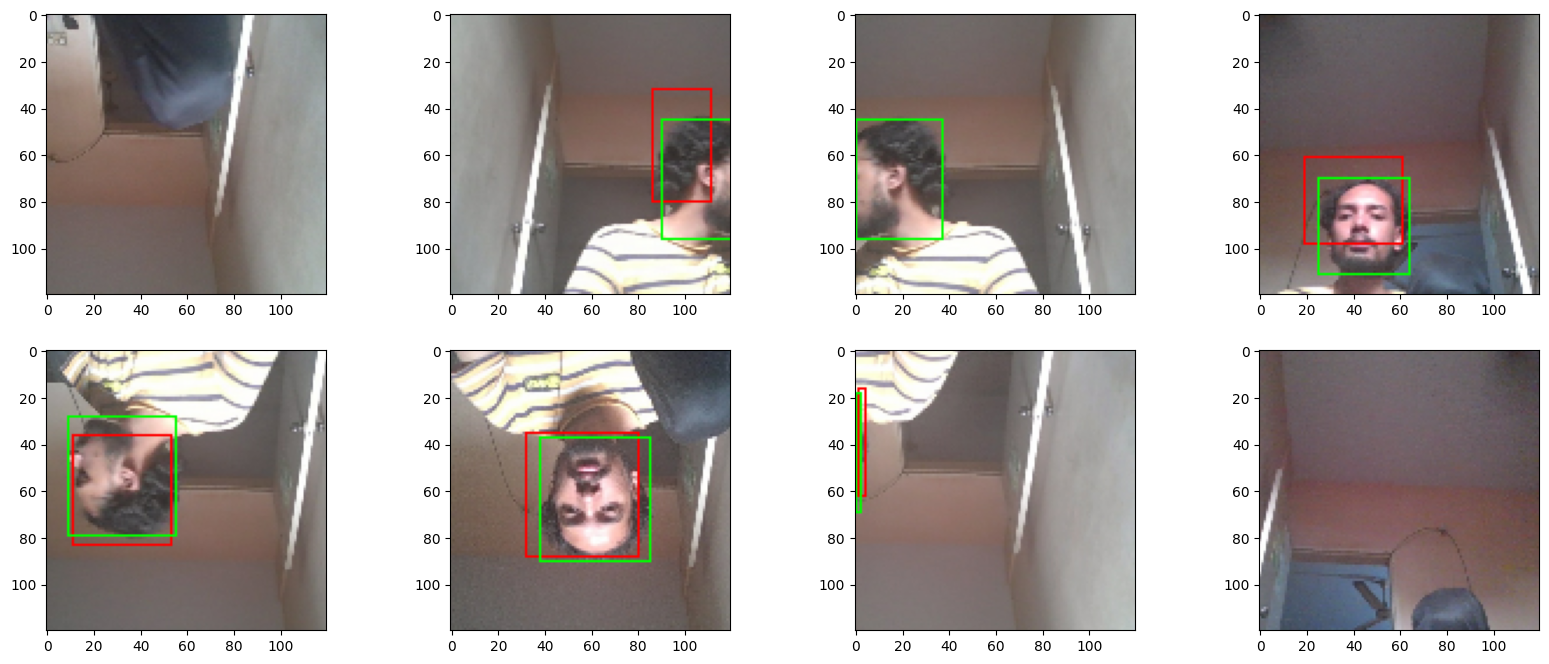

In [205]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(20,8))
for idx in range(8):
    sample_image = (X[idx]).copy()
    sample_actual_coord = y[1][idx]
    sample_pred_coord = ypred[1][idx]
    if ypred[0][idx] > 0.5:
        cv2.rectangle(sample_image,
                    tuple(np.multiply(sample_pred_coord[:2], [120, 120]).astype(int)),
                    tuple(np.multiply(sample_pred_coord[2:], [120, 120]).astype(int)),
                    (255,0,0),1
                    )
    if y[0][idx] > 0:
        cv2.rectangle(sample_image,
                    tuple(np.multiply(sample_actual_coord[:2], [120, 120]).astype(int)),
                    tuple(np.multiply(sample_actual_coord[2:], [120, 120]).astype(int)),
                    (0,255,0),1
                    )
    ax[int(idx/4)][idx%4].imshow(sample_image)

# Saving our model and then loading it back again

In [12]:
#facetracker.save('facetracker.keras')

In [13]:
#model.save('model.keras')

### Reloading model

In [9]:
model_reloaded = load_model('facetracker.keras')

### Analyzing the model's performance on test dataset using our saved file

In [9]:
test_data = test.as_numpy_iterator()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


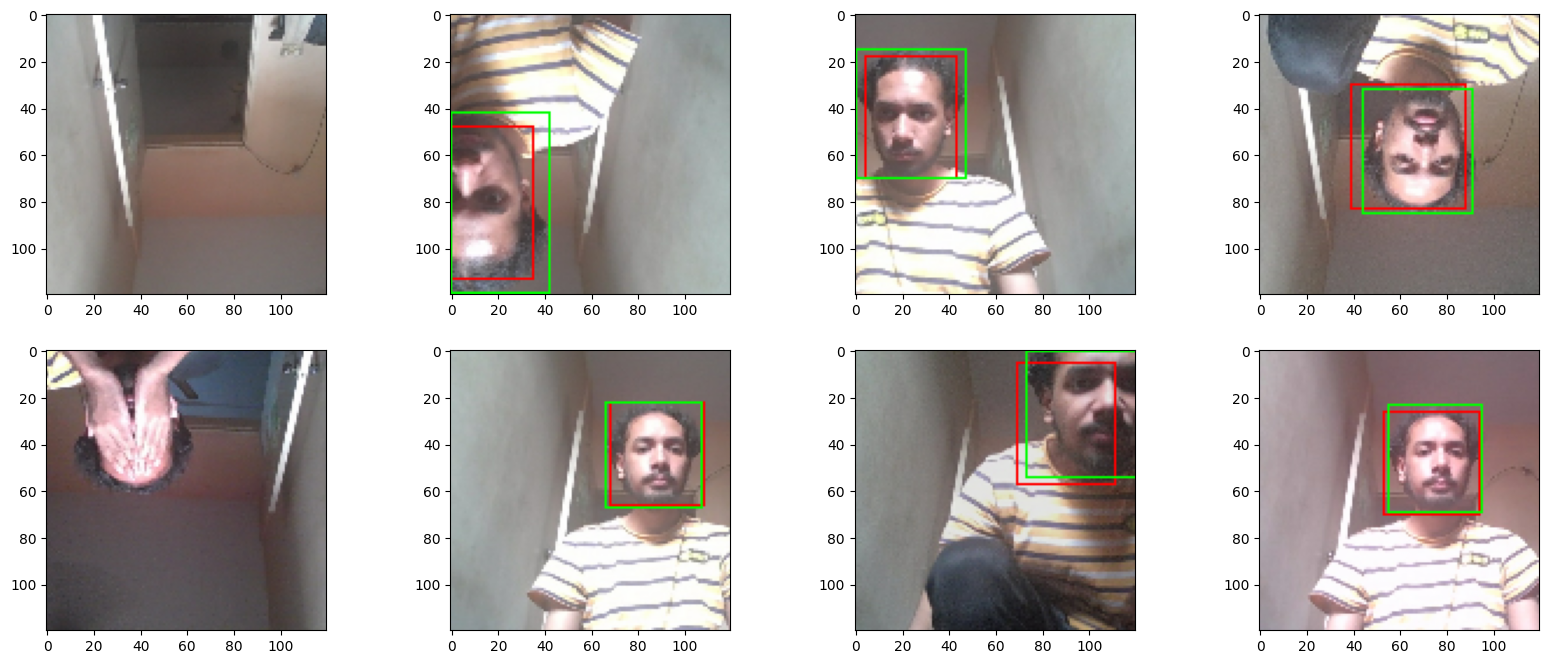

In [10]:
X, y = test_data.next()
ypred = model_reloaded.predict(X)

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(20,8))
for idx in range(8):
    sample_image = (X[idx]).copy()
    sample_actual_coord = y[1][idx]
    sample_pred_coord = ypred[1][idx]
    if ypred[0][idx] > 0.5:
        cv2.rectangle(sample_image,
                    tuple(np.multiply(sample_pred_coord[:2], [120, 120]).astype(int)),
                    tuple(np.multiply(sample_pred_coord[2:], [120, 120]).astype(int)),
                    (255,0,0),1
                    )
    if y[0][idx] > 0:
        cv2.rectangle(sample_image,
                    tuple(np.multiply(sample_actual_coord[:2], [120, 120]).astype(int)),
                    tuple(np.multiply(sample_actual_coord[2:], [120, 120]).astype(int)),
                    (0,255,0),1
                    )
    ax[int(idx/4)][idx%4].imshow(sample_image)

### Analyzing the model's performance on live video

In [10]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _, frame = cap.read()
    frame = frame[50:500, 50:500, :]

    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized_frame = tf.image.resize(rgb_frame, (120, 120))

    prediction = model_reloaded.predict(np.expand_dims(resized_frame/255, 0))
    predicted_class = prediction[0]
    predicted_coords = prediction[1][0]

    if predicted_class > 0.5:
        cv2.rectangle(frame,
                      tuple(np.multiply(predicted_coords[:2], [450, 450]).astype(int)),
                      tuple(np.multiply(predicted_coords[2:], [450, 450]).astype(int)),
                      (255,0,0),1
                      )
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(predicted_coords[:2], [450,450]).astype(int), [0,-30])),
                      tuple(np.add(np.multiply(predicted_coords[:2], [450,450]).astype(int), [80, 0])), 
                            (255,0,0), -1)

        cv2.putText(frame, 'face', tuple(np.add(np.multiply(predicted_coords[:2], [450, 450]).astype(int), [0, -5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('FaceTracker', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 